In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Lambda
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model



(50688, 2) (654, 2)
(500, 2)
(654, 2)
<class 'numpy.ndarray'>
100 25 81
(4, 480, 640, 3) (4, 480, 640, 1)


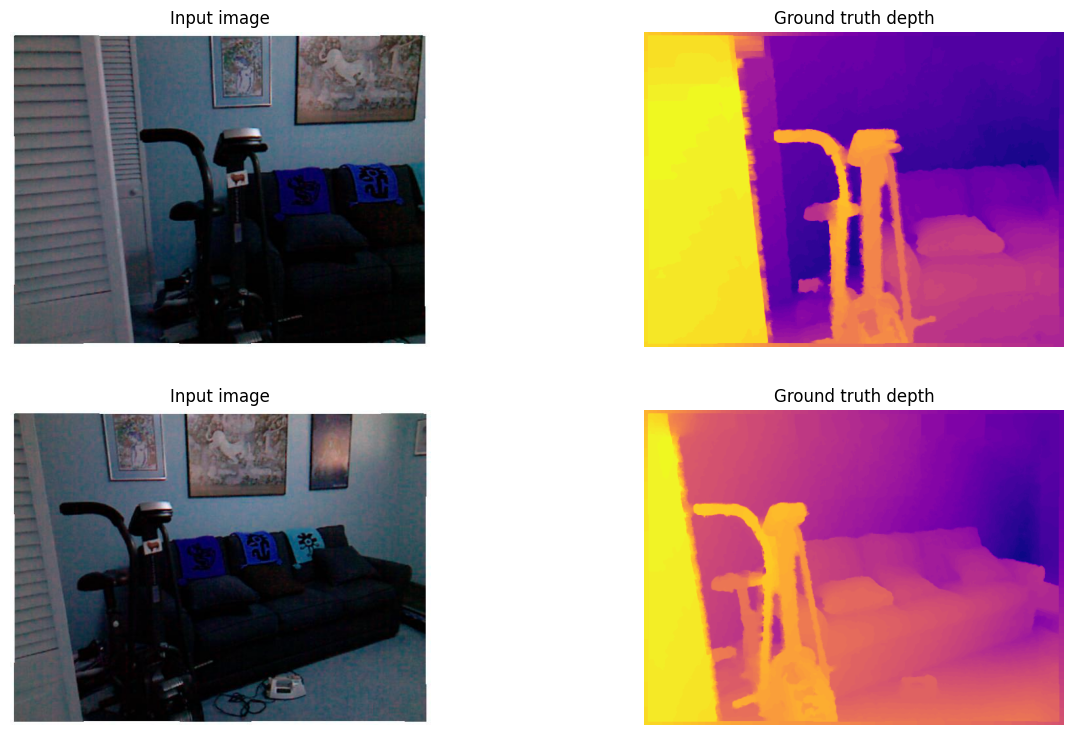

In [2]:
#Hyper params
split = 0.8
height, width = 240, 320

train_df = pd.read_csv(r'D:\New folder (2)\NYU V2\nyu_data\data\nyu2_train.csv',header=None)
test = pd.read_csv(r'D:\New folder (2)\NYU V2\nyu_data\data\nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
base_path = r'E:/Deep Learning/MDE/NYU V2/nyu_data'
train_df['image'] = train_df['image'].map(lambda x:os.path.join(base_path,x))
train_df['depth'] = train_df['depth'].map(lambda x:os.path.join(base_path,x))
test['image'] = test['image'].map(lambda x:os.path.join(base_path,x))
test['depth'] = test['depth'].map(lambda x:os.path.join(base_path,x))

#train_df.head()
#test.head()

print(train_df.shape,test.shape)
train_df=train_df[:500]
print(train_df.shape)

train_split = int(len(train_df)*split)
train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

print(test.shape)
# train_df.head()
print(type(train_df['image'].unique()))
#dd=train_df.set_index('image')['depth'].to_dict()
# dd
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(320, 240)):
        np.random.seed(43)
        self.df = dataframe
        self.height, self.width = dim
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.ids = dataframe['image'].unique()
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size  #number of total batches required

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_data(self, indexes):
        query_imgs = [self.ids[idx] for idx in indexes]
        target_imgs = [self.imgtodpth[img] for img in query_imgs]

        processed_query_img = []
        processed_depth_img = []

        for img_path, depth_path in zip(query_imgs, target_imgs):
            # Preprocess the image
            read_img = cv2.imread(img_path)
            resized_img = cv2.resize(read_img, (640, 480)).astype(np.float32)
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            flip = np.random.choice([False, False])
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            processed_query_img.append(scaled_img)

            # Preprocess the depth map
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread(depth_path), cv2.COLOR_BGR2GRAY), (640, 480)).astype(np.float32)
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            processed_depth_img.append(scaled_img)

        return np.array(processed_query_img), np.array(processed_depth_img)

    def __getitem__(self, index):
        idxs = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        return self.load_data(idxs)
train_generator = DataGenerator(train, batch_size=4, shuffle=True, dim=(640,480))
val_generator = DataGenerator(validation, batch_size=4, shuffle=False, dim=(640,480))
test_generator = DataGenerator(test, batch_size=8, shuffle=False, dim=(640,480))
print(len(train_generator), len(val_generator), len(test_generator))
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
    image = images[i]
    depth = depths[i].squeeze(-1)
    plt.subplot(221+i)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Input image')
    plt.subplot(222+i)
    plt.axis('off')
    plt.imshow(depth,cmap=plt.get_cmap(cmap))
    plt.title('Ground truth depth')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1607s 16s/step - loss: 0.4450 - val_loss: 0.4206
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1577s 16s/step - loss: 0.3627 - val_loss: 0.3731
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1571s 16s/step - loss: 0.3659 - val_loss: 0.3808
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1562s 16s/step - loss: 0.3468 - val_loss: 0.3751
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1553s 16s/step - loss: 0.3445 - val_loss: 0.3709
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1570s 16s/step - loss: 0.3497 - val_loss: 0.3621
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1573s 16s/step - loss: 0.3422 - val_loss: 0.3763
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1572s 16s/step - loss: 0.3409 - val_loss: 0.3741
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1579s 16s/step - loss: 0.3445 - val_loss: 0.3650
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1575s 16s/step - loss: 0.3442 - val_loss: 0.3680


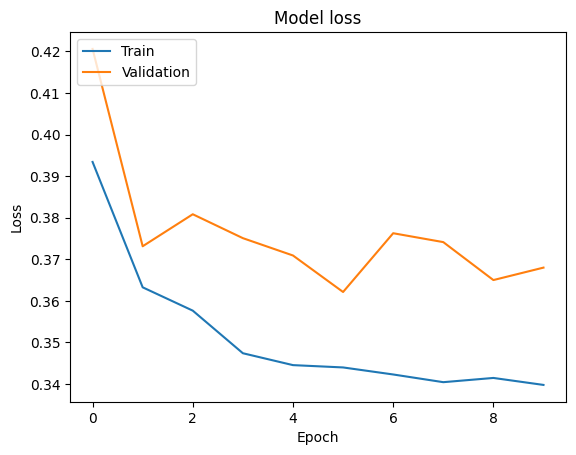

81/81 ━━━━━━━━━━━━━━━━━━━━ 571s 7s/step - loss: 0.3894
Test Loss: 0.3820544183254242
81/81 ━━━━━━━━━━━━━━━━━━━━ 608s 7s/step


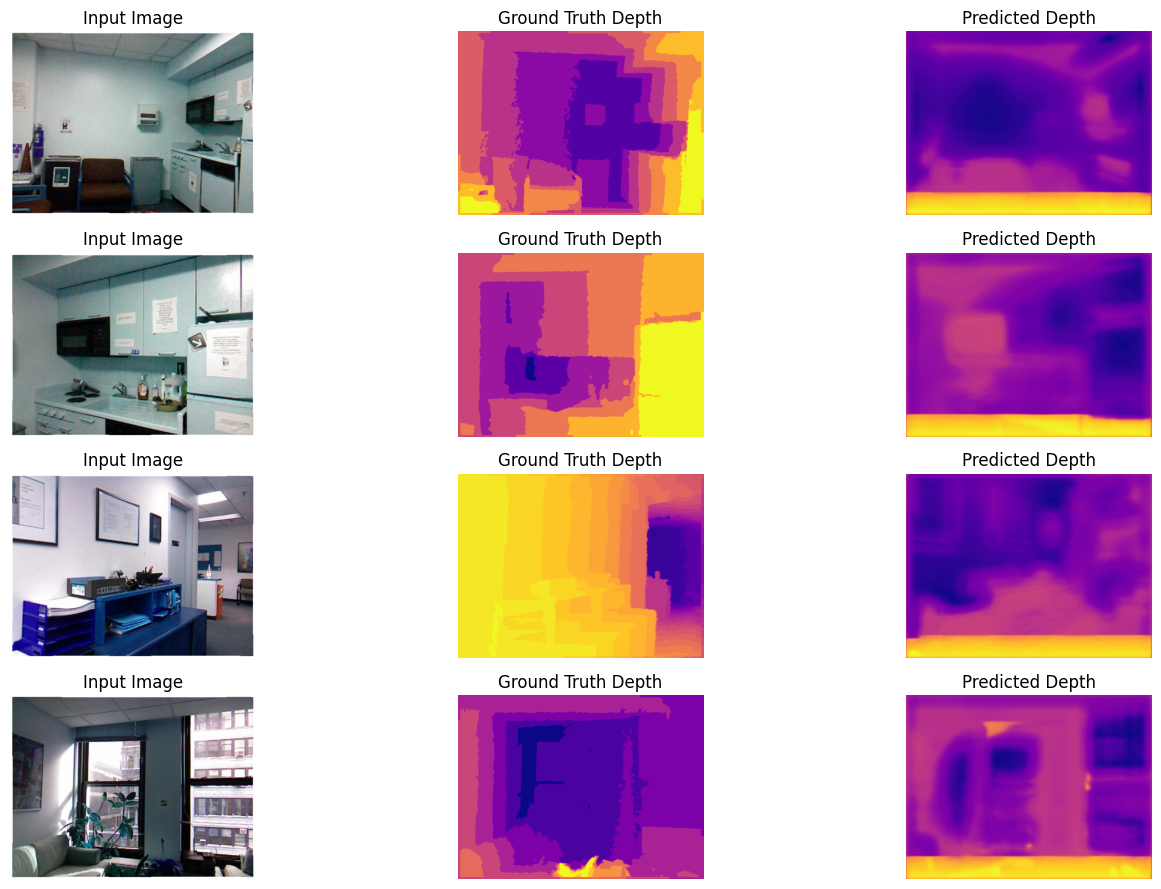

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Define the combined loss function
def combined_loss(y_true, y_pred):
    mse = MeanSquaredError()(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return mse + ssim

# Build the UNet model with batch normalization
def build_depth_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Encoding layers
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck layer
    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)

    # Decoding layers
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 2, padding='same')(up5)
    up5 = BatchNormalization()(up5)
    up5 = LeakyReLU(alpha=0.1)(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(256, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(128, 2, padding='same')(up6)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU(alpha=0.1)(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)
    conv6 = Conv2D(128, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, padding='same')(up7)
    up7 = BatchNormalization()(up7)
    up7 = LeakyReLU(alpha=0.1)(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=0.1)(conv7)
    conv7 = Conv2D(64, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=0.1)(conv7)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv7)

    # Create model
    model = Model(inputs=inputs, outputs=output)

    return model

# Build the model
input_shape = (480, 640, 3)  # Change dimensions according to your image size
depth_model = build_depth_model(input_shape)

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Specify the learning rate here
depth_model.compile(optimizer=optimizer, loss=combined_loss)

# Train the model
history = depth_model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_generator,
)

# Save the trained model
depth_model.save('unet_with_batchnorm.h5')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
test_loss = depth_model.evaluate(test_generator)

print("Test Loss:", test_loss)

# Predict depth maps for the first four samples from the test set
predicted_depths = depth_model.predict(test_generator)

# Load a batch from test_generator for visualization
test_images, test_depths = next(iter(test_generator))

# Plot the first four sample images with their predicted and ground truth depth maps
plt.figure(figsize=(15, 9))
for i in range(4):  # Visualizing only the first four samples
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(test_images[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(test_depths[i].squeeze(-1), cmap=plt.get_cmap('plasma_r'))
    plt.title('Ground Truth Depth')
    plt.axis('off')

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(predicted_depths[i].squeeze(-1), cmap=plt.get_cmap('plasma_r'))
    plt.title('Predicted Depth')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('unet_with_batchnorm.h5')

# If the training history was saved separately, you can use it to get validation loss
# history = model.history.history
# val_loss = history['val_loss']

# If the validation dataset is available, evaluate the model on the validation set
# Assuming you have `x_val` and `y_val` as your validation data and labels
val_loss = model.evaluate(x_val, y_val)

print(f'Validation Loss: {val_loss}')


TypeError: string indices must be integers, not 'str'